In [22]:
import pandas as pd
import numpy as np
import datetime
import os

from time import time

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.svm import SVR

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor 
import xgboost

from MyTransformers import *

from sklearn.model_selection import GridSearchCV

import joblib

%config Completer.use_jedi = False
%matplotlib inline  

In [2]:
daily_data_path = "Data/London/daily_dataset/daily_dataset/"
daily_weather_path = 'Data/London/weather_daily_darksky.csv'
holiday_data_path = 'Data/London/uk_bank_holidays.csv'

f_data_path = "PrepedData/"
f_test_path = f_data_path + "Test/"

f_energy_all_name = "energy_all.csv"

f_data_path = "PrepedData/"
f_test_path = f_data_path + "Test/"
f_energy_clean_name = "energy_clean"

f_energy_avg_name = f_data_path + "energy_avg"
f_energy_avg_hhourly_name = "energy_avg_hhourly"

mode_path = "Modes/"


In [3]:
# Selected weather features
dtypes_in = {'avg_energy':'float32', 'day': 'uint8', 'month': 'uint8', 'temperatureMax': 'float16'}
energy_data = pd.read_csv(f_energy_avg_name+'.csv', dtype=dtypes_in)

energy = energy_data.drop('avg_energy', axis=1)
energy_labels = energy_data['avg_energy'].copy()


In [4]:
# All weather features
energy_data = pd.read_csv(f_energy_avg_all_file)

energy = energy_data.drop(['avg_energy','energy_sum','date'], axis=1)
energy_labels = energy_data['avg_energy'].copy()


NameError: name 'f_energy_avg_all_file' is not defined

In [5]:
# with holiday indicator
dtypes_in = {'avg_energy':'float32', 'day': 'uint8', 'month': 'uint8', 'temperatureMax': 'float16', 'holiday_ind': 'uint8'}
energy_data = pd.read_csv(f_energy_avg_name+f_holiday_data_sufix+'.csv', dtype=dtypes_in)

f_energy = energy_data.drop('avg_energy', axis=1)
f_energy_labels = energy_data['avg_energy'].copy()

NameError: name 'f_holiday_data_sufix' is not defined

In [6]:
#All info hhourly avg data 
dtypes_in_hh_avg = {'avg_energy':'float32','minute': 'uint8', 'hour': 'uint8', 'day': 'uint8', 'month': 'uint8', 'year': 'uint8',
                    'temperature': 'float16', 'holiday_ind': 'uint8'}
f_energy_hh_avg = pd.read_csv(f_data_path+f_energy_avg_hhourly_name+ '_all.csv', dtype=dtypes_in_hh_avg)

energy_hh_avg = f_energy_hh_avg.drop('avg_energy', axis=1)
energy_hh_avg_labels = f_energy_hh_avg['avg_energy'].copy()

In [8]:
#Read all data No Pre compute
energy = pd.read_csv(f_data_path + f_energy_all_name)
energy.date = pd.to_datetime(energy.date,format='%Y-%m-%d').dt.date

weather = pd.read_csv(daily_weather_path)
weather['date']=  pd.to_datetime(weather['time'], format='%Y-%m-%d').dt.date # day is given as timestamp
weather = weather.dropna()

holiday = pd.read_csv(holiday_data_path)
holiday['Bank holidays'] = pd.to_datetime(holiday['Bank holidays'],format='%Y-%m-%d').dt.date

In [58]:
pipeline_avg = Pipeline([
       # ('imputer', SimpleImputer(strategy="median")),
        ('avg_tr', AverageTransformer()),
        ('discreat_date_tr', DiscreatDate()),
        ('weather_tr', WeatherDataMerge(weather=weather)),
        ('holiday_tr', HolidayDataMerge(holiday=holiday)),
        ('select_tr', Select(features=['avg_energy', 'day', 'month', 'temperatureMax', 'holiday_ind'])),
        ('std_scaler', StdScaler(features=['day', 'month', 'temperatureMax', 'holiday_ind']))
    ])

energy_tr = pipeline_avg.fit_transform(energy)

energy_labels = energy_tr['avg_energy'].copy()
energy_tr = energy_tr.drop('avg_energy', axis=1)

In [100]:
class AddAvgDataFromPreviousDays(BaseEstimator, TransformerMixin):
    def __init__(self, days_back=7, data_tag='avg_energy'):
        self.days_back = days_back
        self.data_tag = data_tag
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        for index in range(0, self.days_back):
            X[f'{self.data_tag}_{index}'] = 0.0
            X.loc[self.days_back:len(X),f'{self.data_tag}_{index}'] = X.loc[self.days_back-index -1 :len(X)-index-1,self.data_tag]
        X = X.iloc[self.days_back:,:]
        X.reset_index(drop=True,inplace=True)
        return X

In [94]:
days_back=4; data_tag='temperatureMax'

X = energy_tr.drop(['temperatureMax_0',	'temperatureMax_1'	,'temperatureMax_2'	,'temperatureMax_3'],axis=1)
for index in range(0, days_back):
    X[f'{data_tag}_{index}'] = 0.0
    #X.loc[days_back:len(X),f'{data_tag}_{index}'] = X[data_tag][days_back-index -1 :len(X)-index-1]

X = X.iloc[days_back:,:]

#X.loc[days_back:len(X),f'{data_tag}_0']


In [101]:

days_back = 3
pipeline_avg_past = Pipeline([
       # ('imputer', SimpleImputer(strategy="median")),
        ('avg_tr', AverageTransformer()),
        ('discreat_date_tr', DiscreatDate()),
        ('weather_tr', WeatherDataMerge(weather=weather)),
        ('holiday_tr', HolidayDataMerge(holiday=holiday)),
        ('select_tr', Select(features=['avg_energy', 'day', 'month', 'temperatureMax', 'holiday_ind'])),
        ('AddPastDays_energy', AddAvgDataFromPreviousDays(days_back=days_back)),
        ('AddPastDays_temp', AddAvgDataFromPreviousDays(days_back=days_back, data_tag='temperatureMax')),
        ('std_scaler', StdScaler(features=['day', 'month', 'temperatureMax', 'holiday_ind'],added_past_data=days_back,
                    data_tags=['temperatureMax','avg_energy']))
    ])

energy_past = pipeline_avg_past.fit_transform(energy)

energy_past_labels = energy_past['avg_energy'].copy()
energy_past_tr = energy_past.drop('avg_energy', axis=1)

TypeError: '(slice(2, 827, None), 'avg_energy')' is an invalid key

In [85]:
days_back = 3
pipeline_avg_past = Pipeline([
       # ('imputer', SimpleImputer(strategy="median")),
        ('avg_tr', AverageTransformer()),
        ('discreat_date_tr', DiscreatDate()),
        ('weather_tr', WeatherDataMerge(weather=weather)),
        ('holiday_tr', HolidayDataMerge(holiday=holiday)),
        ('select_tr', Select(features=['avg_energy', 'day', 'month', 'temperatureMax', 'holiday_ind'])),
        ('AddPastDays_energy', AddDiffOfAvgDataFromPreviousDays(days_back=days_back)),
        ('std_scaler', StdScaler(features=['day', 'month', 'temperatureMax', 'holiday_ind'],added_past_data=days_back,
                    data_tags=['avg_energy_diff']))
    ])

energy_past = pipeline_avg_past.fit_transform(energy)

energy_past_labels = energy_past['avg_energy'].copy()
energy_past_tr = energy_past.drop('avg_energy', axis=1)

c:\users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\ipykernel_launcher.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [6]:
poly_features = PolynomialFeatures(degree=3, include_bias=False)
energy_poly = poly_features.fit_transform(energy_tr)

In [5]:
pipeline_house = Pipeline([
       # ('imputer', SimpleImputer(strategy="median")),
        ('clean_tr', RemoveSmallDataHouseHolds()),
        ('discreat_date_tr', DiscreatDate()),
        ('weather_tr', WeatherDataMerge(weather=weather)),
        ('holiday_tr', HolidayDataMerge(holiday=holiday)),
        ('select_tr', Select(features=['energy_sum', 'day', 'month', 'temperatureMax', 'holiday_ind'])),
        ('std_scaler', StdScaler(features=['day', 'month', 'temperatureMax', 'holiday_ind']))
    ])

energy_clean_tr = pipeline_house.fit_transform(energy)

energy_clean_labels = energy_clean_tr['energy_sum'].copy()
energy_clean_tr = energy_clean_tr.drop('energy_sum', axis=1)

# Testing models

In [24]:
resaults_time = []
resaults_mean = []
resaults_std = []
def Test(regressors, lable, cv=10):
    #resaults.append({'lable': lable, 'size': len(regressors)})
    #'lable': lable
    res_t = {}
    res_m = {}
    res_s = {}
    for model in regressors:
        start = time()
        scores = cross_val_score(model['model'], model['train_x'], model['train_y'], scoring="neg_mean_squared_error",
                                 cv=cv, fit_params=model['params'],n_jobs=-1)
        train_time = time() - start 
        rmse_scores = np.sqrt(-scores)
        res_t[model['name']] = train_time
        res_m[model['name']] = rmse_scores.mean()
        res_s[model['name']] = rmse_scores.std()
        print(model['name'], "Training time: %0.3fs" % train_time, rmse_scores.mean() )
        #print("\tTraining time: %0.3fs" % train_time)
        #display_scores(rmse_scores)
        print()
    res_t['lable'] = lable
    res_m['lable'] = lable
    res_s['lable'] = lable
    
    resaults_time.append(res_t)
    resaults_mean.append(res_m)
    resaults_std.append(res_s)

In [25]:
def TestModes(_data, _labes, lable, cv=10):
    data_train, data_val, labels_train, labels_val = train_test_split(_data, _labels)

    regressors = [
        {'model': LinearRegression(),      'params': {}, 'train_x' : _data, 'train_y': _labels, 'name': 'LinReg'},
        {'model': SGDRegressor(),          'params': {}, 'train_x' : _data, 'train_y': _labels, 'name': 'SGDReg'},
        {'model': ElasticNet(),            'params': {}, 'train_x' : _data, 'train_y': _labels, 'name': 'ElaNet'},
        {'model': Lasso(),                 'params': {}, 'train_x' : _data, 'train_y': _labels, 'name': 'Lasso'},
        {'model': Ridge(),                 'params': {}, 'train_x' : _data, 'train_y': _labels, 'name': 'Ridge'},
        {'model': SVR(),                   'params': {}, 'train_x' : _data, 'train_y': _labels, 'name': 'SVR'},
        {'model': DecisionTreeRegressor(), 'params': {}, 'train_x' : _data, 'train_y': _labels, 'name': 'TreeReg'},
        {'model': ExtraTreesRegressor(),   'params': {}, 'train_x' : _data, 'train_y': _labels, 'name': 'ExTreeR'},
        {'model': RandomForestRegressor(), 'params': {}, 'train_x' : _data, 'train_y': _labels, 'name': 'ForestR'},
        {'model': xgboost.XGBRegressor(),  'params': {'eval_set':[(data_val, labels_val)], 'verbose': False},
                                                         'train_x' : data_train,   'train_y': labels_train,     'name': 'XGBReg'},
        {'model': KNeighborsRegressor(),   'params': {}, 'train_x' : _data, 'train_y': _labels, 'name': 'KNeighR'}
    ]
    Test(regressors, lable, cv)

In [10]:
#energy_in_test = energy_clean_tr.head(50000)
#energy_in_labels = energy_clean_labels.head(50000)
energy_in_labels = energy_past_labels
energy_in_test = energy_past_tr
lable = "avg_Holiday_past_temp_3"

In [13]:
energy_train, energy_val, labels_train, labels_val = train_test_split(energy_in_test, energy_in_labels)

regressors = [
    {'model': LinearRegression(),      'params': {}, 'train_x' : energy_in_test, 'train_y': energy_in_labels, 'name': 'LinReg'},
    {'model': SGDRegressor(),          'params': {}, 'train_x' : energy_in_test, 'train_y': energy_in_labels, 'name': 'SGDReg'},
    {'model': ElasticNet(),            'params': {}, 'train_x' : energy_in_test, 'train_y': energy_in_labels, 'name': 'ElaNet'},
    {'model': Lasso(),                 'params': {}, 'train_x' : energy_in_test, 'train_y': energy_in_labels, 'name': 'Lasso'},
    {'model': Ridge(),                 'params': {}, 'train_x' : energy_in_test, 'train_y': energy_in_labels, 'name': 'Ridge'},
    {'model': SVR(),                   'params': {}, 'train_x' : energy_in_test, 'train_y': energy_in_labels, 'name': 'SVR'},
    {'model': DecisionTreeRegressor(), 'params': {}, 'train_x' : energy_in_test, 'train_y': energy_in_labels, 'name': 'TreeReg'},
    {'model': ExtraTreesRegressor(),   'params': {}, 'train_x' : energy_in_test, 'train_y': energy_in_labels, 'name': 'ExTreeR'},
    {'model': RandomForestRegressor(), 'params': {}, 'train_x' : energy_in_test, 'train_y': energy_in_labels, 'name': 'ForestR'},
    {'model': xgboost.XGBRegressor(),  'params': {'eval_set':[(energy_val, labels_val)], 'verbose': False},
                                                     'train_x' : energy_train,   'train_y': labels_train,     'name': 'XGBReg'},
    {'model': KNeighborsRegressor(),   'params': {}, 'train_x' : energy_in_test, 'train_y': energy_in_labels, 'name': 'KNeighR'}
]

Test(regressors)

LinReg Training time: 0.079s 0.9072229636553951

SGDReg Training time: 0.315s 12458882.269098025

ElaNet Training time: 0.064s 0.9036254524971568

Lasso Training time: 0.073s 0.9104129037920083

Ridge Training time: 0.075s 0.9071830963984431

SVR Training time: 0.240s 0.8102513452924128

TreeReg Training time: 0.093s 1.064347949943413

ExTreeR Training time: 1.421s 0.7805541349976257

ForestR Training time: 2.167s 0.8011039057695408

XGBReg Training time: 0.716s 0.7472674233744796

KNeighR Training time: 0.074s 0.8812268513449618



In [92]:
energy_past_tr

,day,month,temperatureMax,holiday_ind,avg_energy_0,avg_energy_1,avg_energy_2,temperatureMax_0,temperatureMax_1,temperatureMax_2
0,1.503062,1.259257,-0.034867,-0.14532,-0.686689,0.255982,-0.058720,-0.176058,-0.025489,-0.117180
1,1.616662,1.259257,-0.286708,-0.14532,-0.594143,-0.686986,0.255940,-0.035890,-0.176708,-0.025811
2,-1.677747,1.530940,-0.242636,-0.14532,-0.843118,-0.594444,-0.687031,-0.287878,-0.036515,-0.177042
3,-1.564146,1.530940,-0.884828,-0.14532,-0.619596,-0.843409,-0.594488,-0.243780,-0.288547,-0.036838
4,-1.450546,1.530940,-0.357538,-0.14532,-0.124083,-0.619896,-0.843454,-0.886351,-0.244441,-0.288890
...,...,...,...,...,...,...,...,...,...,...
817,0.935061,-1.185883,0.084757,-0.14532,0.596087,0.215745,0.076415,-0.276854,-0.326352,-0.559846
818,1.048661,-1.185883,-0.355964,-0.14532,0.019191,0.595738,0.215703,0.083805,-0.277521,-0.326698
819,1.162261,-1.185883,-0.378000,-0.14532,-0.043628,0.018866,0.595698,-0.357175,0.083200,-0.277863
820,1.275861,-1.185883,-0.532252,-0.14532,-0.093304,-0.043951,0.018824,-0.379224,-0.357856,0.082887


# Test Adding info from past days

In [93]:
pipeline_pre = Pipeline([
       # ('imputer', SimpleImputer(strategy="median")),
        ('avg_tr', AverageTransformer()),
        ('discreat_date_tr', DiscreatDate()),
        ('weather_tr', WeatherDataMerge(weather=weather)),
        ('holiday_tr', HolidayDataMerge(holiday=holiday)),
        ('select_tr', Select(features=['avg_energy', 'day', 'month', 'temperatureMax', 'holiday_ind'])),
    ])
energy_ = pipeline_pre.fit_transform(energy)

for d in range(0,10):
    print("################################")
    print(f"\t day: {d}")
    #pipeline_test = Pipeline([
    #        ('AddPastDays_energy', AddAvgDataFromPreviousDays(days_back=d)),
            #('std_scaler', StdScaler(features=['day', 'month', 'temperatureMax', 'holiday_ind'],added_past_data=d))
    #        ('AddPastDays_temp', AddAvgDataFromPreviousDays(days_back=d, data_tag='temperatureMax')),
    #        ('std_scaler', StdScaler(features=['day', 'month', 'temperatureMax', 'holiday_ind'],added_past_data=d,
    #                    data_tag=['temperatureMax','avg_energy']))
    #    ])
    
    pipeline_test = Pipeline([
            ('AddPastDays_energy', AddDiffOfAvgDataFromPreviousDays(days_back=d, data_tag='temperatureMax')),
            ('std_scaler', StdScaler(features=['day', 'month', 'temperatureMax', 'holiday_ind'],added_past_data=d,
                    data_tags=['temperatureMax_diff']))
        ])
     

    energy_2 = pipeline_test.fit_transform(energy_)

    energy__labels = energy_2['avg_energy'].copy()
    energy__tr = energy_2.drop('avg_energy', axis=1)
    
    energy_in_labels = energy__labels
    energy_in_test = energy__tr
    lable = "avg_Holiday_past_temp_diff"+str(d)
    energy_train, energy_val, labels_train, labels_val = train_test_split(energy_in_test, energy_in_labels)

    regressors = [
        {'model': LinearRegression(),      'params': {}, 'train_x' : energy_in_test, 'train_y': energy_in_labels, 'name': 'LinReg'},
        {'model': SGDRegressor(),          'params': {}, 'train_x' : energy_in_test, 'train_y': energy_in_labels, 'name': 'SGDReg'},
        {'model': ElasticNet(),            'params': {}, 'train_x' : energy_in_test, 'train_y': energy_in_labels, 'name': 'ElaNet'},
        {'model': Lasso(),                 'params': {}, 'train_x' : energy_in_test, 'train_y': energy_in_labels, 'name': 'Lasso'},
        {'model': Ridge(),                 'params': {}, 'train_x' : energy_in_test, 'train_y': energy_in_labels, 'name': 'Ridge'},
        {'model': SVR(),                   'params': {}, 'train_x' : energy_in_test, 'train_y': energy_in_labels, 'name': 'SVR'},
        {'model': DecisionTreeRegressor(), 'params': {}, 'train_x' : energy_in_test, 'train_y': energy_in_labels, 'name': 'TreeReg'},
        {'model': ExtraTreesRegressor(),   'params': {}, 'train_x' : energy_in_test, 'train_y': energy_in_labels, 'name': 'ExTreeR'},
        {'model': RandomForestRegressor(), 'params': {}, 'train_x' : energy_in_test, 'train_y': energy_in_labels, 'name': 'ForestR'},
        {'model': xgboost.XGBRegressor(),  'params': {'eval_set':[(energy_val, labels_val)], 'verbose': False},
                                                         'train_x' : energy_train,   'train_y': labels_train,     'name': 'XGBReg'},
        {'model': KNeighborsRegressor(),   'params': {}, 'train_x' : energy_in_test, 'train_y': energy_in_labels, 'name': 'KNeighR'}
    ]

    Test(regressors,lable=lable)

################################
	 day: 0
LinReg Training time: 3.241s 1.0215133623884447

SGDReg Training time: 0.053s 1.021292473652156

ElaNet Training time: 0.047s 1.4008577477232245

Lasso Training time: 0.047s 1.526807186852479

Ridge Training time: 0.052s 1.0214050937319334

SVR Training time: 0.168s 0.8002770673736854

TreeReg Training time: 0.135s 1.1335631513726856

ExTreeR Training time: 0.656s 0.9445499577291245

ForestR Training time: 0.780s 0.921547232954984

XGBReg Training time: 0.558s 0.8547293916296373

KNeighR Training time: 0.046s 0.9526930667392598

################################
	 day: 1


c:\users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\ipykernel_launcher.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

LinReg Training time: 0.043s 0.9419574892229295

SGDReg Training time: 0.046s 0.9424679220395535

ElaNet Training time: 0.044s 1.396644551760096

Lasso Training time: 0.044s 1.522214153018421

Ridge Training time: 0.049s 0.9417039479824112

SVR Training time: 0.163s 0.7795387628471568

TreeReg Training time: 0.048s 1.152915272318697

ExTreeR Training time: 0.650s 0.8144629907805448

ForestR Training time: 0.863s 0.8370806481038547

XGBReg Training time: 0.298s 0.6477862231163881

KNeighR Training time: 0.046s 0.9195831177770938

################################
	 day: 2


c:\users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\ipykernel_launcher.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

LinReg Training time: 0.042s 0.9180628460482051

SGDReg Training time: 0.048s 0.9194980867821483

ElaNet Training time: 0.044s 1.3968451993634077

Lasso Training time: 0.044s 1.5220354926031763

Ridge Training time: 0.045s 0.9177238443494842

SVR Training time: 0.167s 0.7885610887803509

TreeReg Training time: 0.050s 1.1527098397151305

ExTreeR Training time: 0.705s 0.7914301038137689

ForestR Training time: 0.943s 0.8294673236926629

XGBReg Training time: 0.376s 0.6461471273589219

KNeighR Training time: 0.049s 0.9487118106790462

################################
	 day: 3


c:\users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\ipykernel_launcher.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

LinReg Training time: 0.041s 0.9072229636553952

SGDReg Training time: 0.048s 0.9060521718252904

ElaNet Training time: 0.045s 1.3962400453902335

Lasso Training time: 0.042s 1.5210356923762813

Ridge Training time: 0.045s 0.9068283037230753

SVR Training time: 0.166s 0.8018974603135988

TreeReg Training time: 0.051s 1.2182286404496032

ExTreeR Training time: 0.741s 0.7827219646256743

ForestR Training time: 1.042s 0.8262165240419593

XGBReg Training time: 0.399s 0.8250708643592292

KNeighR Training time: 0.049s 0.9890254684583442

################################
	 day: 4


c:\users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\ipykernel_launcher.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

LinReg Training time: 0.042s 0.8970911143591058

SGDReg Training time: 0.048s 0.8978976113973914

ElaNet Training time: 0.046s 1.3960910325117246

Lasso Training time: 0.044s 1.520536735157299

Ridge Training time: 0.045s 0.8966435011053034

SVR Training time: 0.174s 0.8306196499885526

TreeReg Training time: 0.054s 1.216209599715198

ExTreeR Training time: 0.767s 0.7712542055035051

ForestR Training time: 1.122s 0.8274548237941481

XGBReg Training time: 0.471s 0.6320715057549976

KNeighR Training time: 0.053s 1.0433669019829925

################################
	 day: 5


c:\users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\ipykernel_launcher.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

LinReg Training time: 0.045s 0.8943371267192266

SGDReg Training time: 0.048s 0.8938254537628592

ElaNet Training time: 0.048s 1.395153854326597

Lasso Training time: 0.045s 1.5193421585301288

Ridge Training time: 0.049s 0.8938694922390089

SVR Training time: 0.176s 0.8530526121651963

TreeReg Training time: 0.053s 1.1716427802934863

ExTreeR Training time: 0.817s 0.7717835853817816

ForestR Training time: 1.210s 0.8339088684208708

XGBReg Training time: 0.484s 0.6655742261881021

KNeighR Training time: 0.052s 1.0478235281768544

################################
	 day: 6


c:\users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\ipykernel_launcher.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

LinReg Training time: 0.045s 0.8895844326710559

SGDReg Training time: 0.050s 0.8892373618181543

ElaNet Training time: 0.045s 1.3946422730047439

Lasso Training time: 0.046s 1.5186642500197287

Ridge Training time: 0.046s 0.889094407030187

SVR Training time: 0.179s 0.8723116747037547

TreeReg Training time: 0.053s 1.112534309420845

ExTreeR Training time: 0.853s 0.7727913102418666

ForestR Training time: 1.298s 0.8292407652126486

XGBReg Training time: 0.531s 0.7930785323738341

KNeighR Training time: 0.051s 1.0946066242048065

################################
	 day: 7


c:\users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\ipykernel_launcher.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

LinReg Training time: 0.043s 0.8852491689051402

SGDReg Training time: 0.050s 0.8840456017146583

ElaNet Training time: 0.045s 1.3942310700262674

Lasso Training time: 0.046s 1.5179219603829364

Ridge Training time: 0.046s 0.8847479766275355

SVR Training time: 0.183s 0.9029898854173076

TreeReg Training time: 0.055s 1.1905295255956958

ExTreeR Training time: 0.890s 0.7615124340836682

ForestR Training time: 1.393s 0.8351861036686575

XGBReg Training time: 0.583s 0.8152287041318447

KNeighR Training time: 0.050s 1.107518414080762

################################
	 day: 8


c:\users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\ipykernel_launcher.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

LinReg Training time: 0.043s 0.8828819610754255

SGDReg Training time: 0.051s 0.884916903695333

ElaNet Training time: 0.044s 1.395136033401974

Lasso Training time: 0.044s 1.5185144447474088

Ridge Training time: 0.048s 0.8823582430924249

SVR Training time: 0.186s 0.9350392741555662

TreeReg Training time: 0.058s 1.2544068188340514

ExTreeR Training time: 0.929s 0.7656324760005775

ForestR Training time: 1.540s 0.8254987760774443

XGBReg Training time: 0.644s 0.6169080115022252

KNeighR Training time: 0.052s 1.155024094835241

################################
	 day: 9


c:\users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\ipykernel_launcher.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

LinReg Training time: 0.045s 0.8811505227538727

SGDReg Training time: 0.049s 0.8796163592474275

ElaNet Training time: 0.045s 1.394412979775371

Lasso Training time: 0.043s 1.5169761979023337

Ridge Training time: 0.045s 0.8806181156246703

SVR Training time: 0.185s 0.9629230941546579

TreeReg Training time: 0.055s 1.1722835247200092

ExTreeR Training time: 0.962s 0.7519351474615765

ForestR Training time: 1.613s 0.8287106688166

XGBReg Training time: 0.666s 0.7642529528908767

KNeighR Training time: 0.052s 1.1775472875930861



In [14]:
d = 10
pipeline_avg_hh = Pipeline([
        ('AddPastDays_energy', AddAvgDataFromPreviousDays(days_back=d)),
        ('AddPastDays_temp', AddAvgDataFromPreviousDays(days_back=d, data_tag='temperature')),
        ('AddPastDays_energy_diff', AddDiffOfAvgDataFromPreviousDays(days_back=d)),
        ('AddPastDays_temp_diff', AddDiffOfAvgDataFromPreviousDays(days_back=d, data_tag='temperature')),
        ('std_scaler', StdScaler(features=['minute','hour','day', 'month', 'year','temperature', 'holiday_ind']
                    ,added_past_data=d, data_tags=['avg_energy','temperature','avg_energy_diff','temperature_diff']))
    ])
energy_avg_hh = pipeline_avg_hh.fit_transform(f_energy_hh_avg)


c:\users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\ipykernel_launcher.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\ipykernel_launcher.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

In [18]:
#save procesed data 
energy_avg_hh.to_csv(f_data_path + f_energy_avg_hhourly_name+"_all_added_past.csv", mode='w', index=False, header=True) 

In [30]:

_labels = energy_avg_hh['avg_energy'].copy()
_data = energy_avg_hh.drop('avg_energy', axis=1)

l_energy_days = [f"avg_energy_{i}" for i in range(0,d)]
l_temp_days = [f"temperature_{i}" for i in range(0,d)]
l_energy_diff_days = [f"avg_energy_diff_{i}" for i in range(0,d)]
l_temp_diff_days = [f"temperature_diff_{i}" for i in range(0,d)]

for day in range(0,10):
    print("################################")
    print(f"\t day: {day}")
    
    data = _data.drop(l_energy_days[day:], axis=1)
    data = data.drop(l_temp_days, axis=1)
    data = data.drop(l_energy_diff_days, axis=1)
    data = data.drop(l_temp_diff_days, axis=1)
    lable = "avg_hh_past_energy_"+str(day)
    TestModes(data, _labels, lable)
    
for day in range(0,10):
    print("################################")
    print(f"\t day: {day}")
    
    data = _data.drop(l_energy_days, axis=1)
    data = data.drop(l_temp_days[day:], axis=1)
    data = data.drop(l_energy_diff_days, axis=1)
    data = data.drop(l_temp_diff_days, axis=1)
    lable = "avg_hh_past_temp_"+str(day)
    TestModes(data, _labels, lable)

for day in range(0,10):
    print("################################")
    print(f"\t day: {day}")
    
    data = _data.drop(l_energy_days, axis=1)
    data = data.drop(l_temp_days, axis=1)
    data = data.drop(l_energy_diff_days[day:], axis=1)
    data = data.drop(l_temp_diff_days, axis=1)
    lable = "avg_hh_past_enrgyDiff_"+str(day)
    TestModes(data, _labels, lable)
    
for day in range(0,10):
    print("################################")
    print(f"\t day: {day}")
    
    data = _data.drop(l_energy_days, axis=1)
    data = data.drop(l_temp_days, axis=1)
    data = data.drop(l_energy_diff_days, axis=1)
    data = data.drop(l_temp_diff_days[day:], axis=1)
    lable = "avg_hh_past_tempDiff_"+str(day)
    TestModes(data, _labels, lable)

################################
	 day: 0
LinReg Training time: 0.169s 0.05000671135117063

SGDReg Training time: 0.452s 0.050177634481869404

ElaNet Training time: 0.272s 0.07728817023973758

Lasso Training time: 0.268s 0.07728817023973758

Ridge Training time: 0.241s 0.0500067186334137

SVR Training time: 5.381s 0.054330504787799994

TreeReg Training time: 1.018s 0.028565829807260506

ExTreeR Training time: 31.058s 0.02194622744687603

ForestR Training time: 36.227s 0.023188052414550485

XGBReg Training time: 9.336s 0.014848311143304335

KNeighR Training time: 10.557s 0.04090133533616926

################################
	 day: 1
LinReg Training time: 0.340s 0.01559314183123319

SGDReg Training time: 0.476s 0.015601597082706763

ElaNet Training time: 0.160s 0.07728817023973758

Lasso Training time: 0.158s 0.07728817023973758

Ridge Training time: 0.365s 0.01559326720931165

SVR Training time: 1.354s 0.050842791211029637

TreeReg Training time: 1.163s 0.011850487360421111

ExTreeR Tra

ExTreeR Training time: 31.959s 0.021245744712451484

ForestR Training time: 56.224s 0.022603985347019843

XGBReg Training time: 10.199s 0.015374398588325103

KNeighR Training time: 11.851s 0.04257167345665568

################################
	 day: 4
LinReg Training time: 0.231s 0.04928269500201406

SGDReg Training time: 0.300s 0.04928420370631599

ElaNet Training time: 0.221s 0.07728817023973758

Lasso Training time: 0.208s 0.07728817023973758

Ridge Training time: 0.207s 0.04928257522131348

SVR Training time: 4.498s 0.053909214604094736

TreeReg Training time: 1.244s 0.028313812692246382

ExTreeR Training time: 35.549s 0.021154608436968658

ForestR Training time: 64.870s 0.02252741549897192

XGBReg Training time: 11.304s 0.01555360869489245

KNeighR Training time: 11.999s 0.04276119157946216

################################
	 day: 5
LinReg Training time: 0.280s 0.04920115899644794

SGDReg Training time: 0.317s 0.04923899237159125

ElaNet Training time: 0.220s 0.07728817023973758



Ridge Training time: 0.223s 0.042538786310124574

SVR Training time: 2.012s 0.05608613939087563

TreeReg Training time: 2.666s 0.025510766507202

ExTreeR Training time: 63.643s 0.017125730745627628

ForestR Training time: 127.475s 0.017966225206981407

XGBReg Training time: 28.712s 0.013297555923013713

KNeighR Training time: 10.434s 0.029531865465798068

################################
	 day: 8
LinReg Training time: 0.288s 0.04182064125291387

SGDReg Training time: 0.347s 0.04187738658717749

ElaNet Training time: 0.252s 0.07728817023973758

Lasso Training time: 0.253s 0.07728817023973758

Ridge Training time: 0.239s 0.0418206424859634

SVR Training time: 2.426s 0.05557878377821355

TreeReg Training time: 2.324s 0.02531206298539506

ExTreeR Training time: 55.480s 0.016917351140219018

ForestR Training time: 130.537s 0.01770808172432049

XGBReg Training time: 31.949s 0.013097006726268155

KNeighR Training time: 11.927s 0.028762557848371506

################################
	 day: 9
Li

In [35]:
_labels = energy_avg_hh['avg_energy'].copy()
_data = energy_avg_hh.drop('avg_energy', axis=1)

l_energy_days = [f"avg_energy_{i}" for i in range(0,d)]
l_temp_days = [f"temperature_{i}" for i in range(0,d)]
l_energy_diff_days = [f"avg_energy_diff_{i}" for i in range(0,d)]
l_temp_diff_days = [f"temperature_diff_{i}" for i in range(0,d)]

for day in range(0,5):
    print("################################")
    print(f"\t day: {day}")
    
    data = _data.drop(l_energy_days[day:], axis=1)
    data = data.drop(l_temp_days, axis=1)
    data = data.drop(l_energy_diff_days[day:], axis=1)
    data = data.drop(l_temp_diff_days, axis=1)
    lable = "avg_hh_past_energy_and_energyDiff"+str(day)
    TestModes(data, _labels, lable)
    
for day in range(0,5):
    print("################################")
    print(f"\t day: {day}")
    
    data = _data.drop(l_energy_days, axis=1)
    data = data.drop(l_temp_days[day:], axis=1)
    data = data.drop(l_energy_diff_days, axis=1)
    data = data.drop(l_temp_diff_days[day:], axis=1)
    lable = "avg_hh_past_temp_and_tempDiff"+str(day)
    TestModes(data, _labels, lable)

for day in range(0,5):
    print("################################")
    print(f"\t day: {day}")
    
    data = _data.drop(l_energy_days[day:], axis=1)
    data = data.drop(l_temp_days[day:], axis=1)
    data = data.drop(l_energy_diff_days, axis=1)
    data = data.drop(l_temp_diff_days, axis=1)
    lable = "avg_hh_past_temp_and_energy"+str(day)
    TestModes(data, _labels, lable)
    
for day in range(0,5):
    print("################################")
    print(f"\t day: {day}")
    
    data = _data.drop(l_energy_days[day:], axis=1)
    data = data.drop(l_temp_days[day:], axis=1)
    data = data.drop(l_energy_diff_days, axis=1)
    data = data.drop(l_temp_diff_days, axis=1)
    lable = "avg_hh_past_tempDiff_and_energyDiff"+str(day)
    TestModes(data, _labels, lable)
    

l_labels_time = ['minute','hour','day','month','year']
l_lables = ['temperature','holiday_ind']
data = _data.drop(l_energy_days, axis=1)
data = data.drop(l_temp_days, axis=1)
data = data.drop(l_energy_diff_days, axis=1)
data = data.drop(l_temp_diff_days, axis=1)
data_no_time = data.drop(l_labels_time, axis=1)
print("##############NO Time##################")
TestModes(data_no_time, _labels, 'avg_hh_no_time')

print("##############NO Time, no holiday ind##################")
TestModes(data_no_time.drop('holiday_ind', axis=1), _labels, 'avg_hh_no_time_no_holiday_ind')

print("##############No Temp##################")
TestModes(data.drop('temperature', axis=1), _labels, 'avg_hh_no_temp')

################################
	 day: 0
LinReg Training time: 4.773s 0.05000671135117063

SGDReg Training time: 0.279s 0.04983026315257834

ElaNet Training time: 0.201s 0.07728817023973758

Lasso Training time: 0.209s 0.07728817023973758

Ridge Training time: 0.330s 0.0500067186334137

SVR Training time: 4.688s 0.054330504787799994

TreeReg Training time: 1.101s 0.02861870248602958

ExTreeR Training time: 29.320s 0.02192516985797857

ForestR Training time: 31.530s 0.023186375040999213

XGBReg Training time: 7.570s 0.014912987748628315

KNeighR Training time: 9.990s 0.04090133533616926

################################
	 day: 1
LinReg Training time: 0.448s 1.3501574478622607e-16

SGDReg Training time: 0.330s 1.3253755438326833e-05

ElaNet Training time: 0.230s 0.07728817023973758

Lasso Training time: 0.222s 0.07728817023973758

Ridge Training time: 0.329s 3.7010460206362152e-06

SVR Training time: 1.122s 0.049770655451188466

TreeReg Training time: 1.165s 0.001963633723032119

ExTree

ExTreeR Training time: 65.663s 0.008063661860511728

ForestR Training time: 118.295s 0.008465391993899112

XGBReg Training time: 24.214s 0.007318389424957074

KNeighR Training time: 16.144s 0.018160477213932397

################################
	 day: 4
LinReg Training time: 0.547s 0.01143660043758749

SGDReg Training time: 0.477s 0.011604486498621832

ElaNet Training time: 0.339s 0.07728817023973758

Lasso Training time: 0.536s 0.07728817023973758

Ridge Training time: 0.516s 0.011436585365687268

SVR Training time: 1.581s 0.0491304162091004

TreeReg Training time: 3.658s 0.012066946863908792

ExTreeR Training time: 64.114s 0.00804861670880463

ForestR Training time: 146.323s 0.008450210957635913

XGBReg Training time: 27.862s 0.007324166372536395

KNeighR Training time: 17.131s 0.018276710954318764

################################
	 day: 0
LinReg Training time: 0.283s 0.05000671135117063

SGDReg Training time: 0.379s 0.05011246687565736

ElaNet Training time: 0.251s 0.07728817023973

In [37]:
#print("Mean values:")
test = pd.DataFrame(resaults_mean)
test.to_csv("avg_hh_test.csv", mode='w', index=False, header=True) 
#pd.DataFrame(resaults_mean)

In [38]:
#print("Standard deviation:")
test = pd.DataFrame(resaults_std)
test.to_csv("avg_hh_test_std.csv", mode='w', index=False, header=True) 
#pd.DataFrame(resaults_std)

In [39]:
#print("Train Time:")
test = pd.DataFrame(resaults_std)
test.to_csv("avg_hh_test_time.csv", mode='w', index=False, header=True) 
#pd.DataFrame(resaults_time)

In [ ]:
regressors = [
    {'model': cumlLinReg(), 'params': {}, 'train_x' : energy_in_test, 'train_y': energy_in_labels},
    {'model': cumlSGD(), 'params': {}, 'train_x' : energy_in_test, 'train_y': energy_in_labels},
    {'model': cumlElastincNet(), 'params': {}, 'train_x' : energy_in_test, 'train_y': energy_in_labels},
    {'model': cumlLasso(), 'params': {}, 'train_x' : energy_in_test, 'train_y': energy_in_labels},
    {'model': cumlRidge(), 'params': {}, 'train_x' : energy_in_test, 'train_y': energy_in_labels},
    #{'model': SVR(), 'params': {}, 'train_x' : energy_in_test, 'train_y': energy_in_labels},
    {'model': cumlForestReg(), 'params': {}, 'train_x' : energy_in_test, 'train_y': energy_in_labels},
    #{'model': ExtraTreesRegressor(), 'params': {}, 'train_x' : energy_in_test, 'train_y': energy_in_labels},
    #{'model': RandomForestRegressor(), 'params': {}, 'train_x' : energy_in_test, 'train_y': energy_in_labels},
    #{'model': xgboost.XGBRegressor(), 'params': {'eval_set':[(energy_val, labels_val)], 'verbose': False},
    # 'train_x' : energy_train, 'train_y': labels_train},
    #{'model': KNeighborsRegressor(), 'params': {}, 'train_x' : energy_in_test, 'train_y': energy_in_labels}
]


Test(regressors)

In [78]:
param_grid = [
    {'n_estimators': [3, 10, 30, 50], 'max_features': [2, 4, 8, 16, 21]},
    {'bootstrap': [False], 'n_estimators': [3, 10 , 30 , 50], 'max_features': [2, 4, 8, 16, 21]},
  ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(energy_tr, energy_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 8, 16, 21],
                          'n_estimators': [3, 10, 30, 50]},
                         {'bootstrap': [False],
                          'max_features': [2, 4, 8, 16, 21],
                          'n_estimators': [3, 10, 30, 50]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [79]:
grid_search.best_params_

{'max_features': 2, 'n_estimators': 50}

In [80]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

1.8828952186062002 {'max_features': 2, 'n_estimators': 3}
1.3452599500830404 {'max_features': 2, 'n_estimators': 10}
1.0910316284266925 {'max_features': 2, 'n_estimators': 30}
1.0696205622836068 {'max_features': 2, 'n_estimators': 50}
1.2251345556538475 {'max_features': 4, 'n_estimators': 3}
1.398524321200443 {'max_features': 4, 'n_estimators': 10}
1.3036456818121962 {'max_features': 4, 'n_estimators': 30}
1.1633464869213932 {'max_features': 4, 'n_estimators': 50}
1.393035401373218 {'max_features': 8, 'n_estimators': 3}
1.946273684185477 {'max_features': 8, 'n_estimators': 10}
1.3422822484775436 {'max_features': 8, 'n_estimators': 30}
1.744389474549438 {'max_features': 8, 'n_estimators': 50}
2.533334769638574 {'max_features': 16, 'n_estimators': 3}
1.7677375876563481 {'max_features': 16, 'n_estimators': 10}
1.7409335056467463 {'max_features': 16, 'n_estimators': 30}
1.86970262554365 {'max_features': 16, 'n_estimators': 50}
2.784389129832759 {'max_features': 21, 'n_estimators': 3}
1.979

In [ ]:
pd.DataFrame(grid_search.cv_results_)

In [81]:
param_grid = [
    {'n_estimators': [3, 10, 30, 50], 'max_features': [2, 4, 8, 16, 21]},
    {'bootstrap': [False], 'n_estimators': [3, 10 , 30 , 50], 'max_features': [2, 4, 8, 16, 21]},
  ]

lin_reg = LinearRegression()

grid_search = GridSearchCV(lin_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(energy_tr, energy_labels)

ValueError: Invalid parameter max_features for estimator LinearRegression(). Check the list of available parameters with `estimator.get_params().keys()`.

In [83]:
lin_reg.get_params().keys()

dict_keys(['copy_X', 'fit_intercept', 'n_jobs', 'normalize', 'positive'])

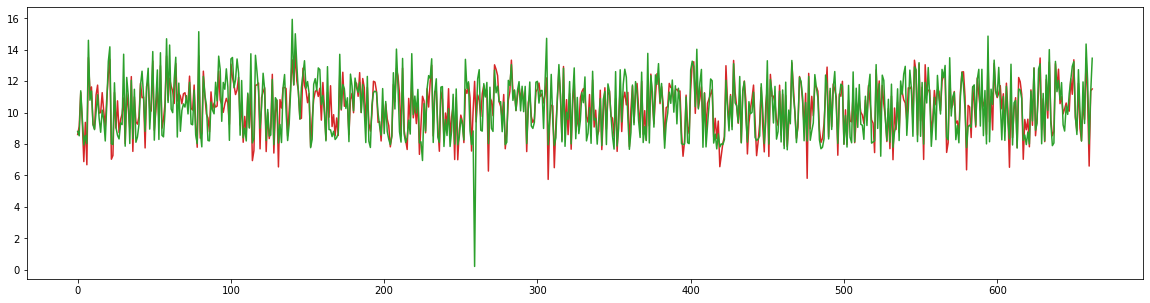

In [37]:
figure, axis = plt.subplots(figsize = (20,5))
axis.plot(range(len(energy_predictions)), energy_predictions, color = 'tab:red')
axis.plot(range(len(energy_labels)), energy_labels, color = 'tab:green')
  


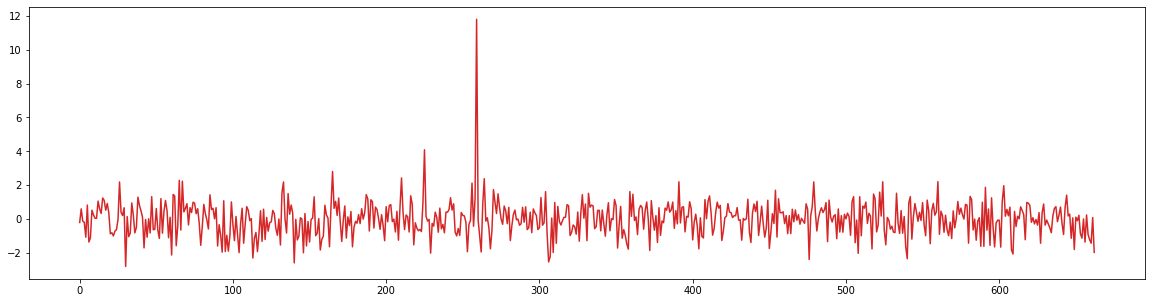

In [40]:
joblib.dump(my_model, "my_model.pkl")
my_model_loaded = joblib.load("my_model.pkl")